In [1]:
# -*- coding: utf-8 -*-

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from html_table_parser import parser_functions as parse
from time import sleep
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import random
import matplotlib.pyplot as plt
import math
% matplotlib inline

In [3]:
import lxml
import requests
import html5lib
pd.options.display.max_rows = 50

In [4]:
from bokeh.models import HoverTool, CategoricalColorMapper, OpenURL, TapTool, ResetTool
from bokeh.plotting import ColumnDataSource, figure, output_file, show, save, output_notebook
from bokeh.io import curdoc
from bokeh.models.glyphs import VBar

In [ ]:
table_pages = ['https://en.wikipedia.org/wiki/List_of_battles_before_301',
               'https://en.wikipedia.org/wiki/List_of_battles_301%E2%80%931300',
               'https://en.wikipedia.org/wiki/List_of_battles_1301%E2%80%931600',
               'https://en.wikipedia.org/wiki/List_of_battles_since_2001']

In [ ]:
list_pages = ['https://en.wikipedia.org/wiki/List_of_battles_1601%E2%80%931800',
               'https://en.wikipedia.org/wiki/List_of_battles_1801%E2%80%931900',
               'https://en.wikipedia.org/wiki/List_of_battles_1901%E2%80%932000',]

In [ ]:
def list_battles(url):
    req = requests.get(url)
    print req.status_code
    era = req.content
    era_soup = BeautifulSoup(era)
    bullets = era_soup.find_all('li')
    
    for bullet in bullets:
        print bullet
        if 'title' in str(bullet):
#             if 'expedition' or 'recapture' or 'capture' or 'war' or 'action' or 'battle' or 'siege' or 'operation' or 'fall' in str(bullet).lower():
#                 if 'List+of+battles' not in str(bullet):
                    if 'footer' not in str(bullet):
                        link = bullet.a['href']
                        link_list.append(link)

                        title = bullet.a['title']
                        title_list.append(title)
                    else:
                        print 'NEXT ENTRY: ' + str(bullet)
#                 else:
#                     print 'NEXT ENTRY: ' + str(bullet)
#             else:
#                 print 'NEXT ENTRY: ' + str(bullet)
        else: 
            print 'NEXT ENTRY' + str(bullet)
                    

In [ ]:
title_list = []
link_list = []
for url in list_pages:
    list_battles(url)

In [ ]:
link_list

In [ ]:
df_late_battles = pd.concat([pd.Series(link_list), pd.Series(title_list)], axis = 1).drop_duplicates()

In [ ]:
df_late_battles = df_late_battles.rename(columns = {0:'url', 1:'Battle'})

In [ ]:
df_late_battles

In [ ]:
df_late_battles[~df_late_battles['Battle'].str.contains('Battle' or 'Operation')]

In [ ]:
df_late_battles.to_csv('battle_list_1600-', encoding = 'utf-8')

In [ ]:
df_late_battles = pd.read_csv('battle_list_1600-.csv', encoding = 'utf-8')

In [ ]:
df_late_battles.head()

In [ ]:
df_late_battles = df_late_battles.drop(['Column1', 'Column4'], axis = 1)
df_late_battles.columns = df_late_battles.iloc[0]
df_late_battles = df_late_battles.drop(0)

In [ ]:
battle_list = []
link_list = []

In [ ]:
def early_battles(link):
    req = requests.get(link)
    print req.status_code
    era = req.content
    era_soup = BeautifulSoup(era)
    tables = era_soup.find_all('table', {'class': 'wikitable'})

    for table in tables:
        cells = table.find_all('td')
        for cell in cells:
            if cell.a is not None:
                a = ['Fall', 'Battle', 'Siege', 'Capture', 'Operation', 'Action', 'Recapture']
                if any(x in str(cell.a['href']) for x in a):
                    battle_list.append(cell.a['title'])
                    link_list.append(cell.a['href'])

In [ ]:
for page in table_pages:
    print page
    early_battles(page)

In [ ]:
df_battles = pd.DataFrame({'battle': battle_list,
                          'link':link_list})

In [ ]:
df_battles = df_battles.rename(columns = {'link':'url', 'battle':'Battle'})

In [ ]:
len(df_battles)

In [ ]:
len(df_late_battles)

In [ ]:
df_battles.head()

In [ ]:
df_url = pd.concat([df_late_battles, df_battles]).reset_index(drop = True)

In [ ]:
len(df_url)

In [ ]:
len(df_url.drop_duplicates())

In [ ]:
s_req = requests.get('https://en.wikipedia.org/Alexander_the_Great')

soup = BeautifulSoup(s_req.text)

ul = soup.find('ul', {'class':'redirectText'})

In [ ]:
if ul is not None:
    print 'works'

In [ ]:
df_battle_all = pd.DataFrame()
df_battle = pd.DataFrame()
def table_scrape(url, name):
#     sleep(1)
    print name
    link = 'https://en.wikipedia.org' + url
    b_req = requests.get(link)

    soup = BeautifulSoup(b_req.text)
    
    bell = soup.find('table', {'class':'infobox vevent'})
    
    if bell is not None:

        details = pd.DataFrame(parse.make2d(bell))
    else:
        return b_req
    

    if 'Belligerents' in str(bell):
    
        clean_rows = details.drop_duplicates(0).set_index(0,drop = True).loc[['Date', 'Location', 'Result'],:]

        clean_col = clean_rows.transpose().reset_index(drop = True)

        df_x_bells = pd.DataFrame()

        html_table = bell.find_all('tr')
        bell_list = []
        bell_y_list = []

        for index, cell in zip(range(0, len(html_table)), html_table):
            if 'Commanders and leaders' in str(cell):
                leaders = html_table[index + 1]
                cells = leaders.find_all('td')
                count = 0
                for cell in cells:
                    count += 1
                    anchors = cell.find_all('a')
                    for anchor in anchors:
                        if 'title' in str(anchor):
                            if 'class="image"' in str(anchor):
                                cl = 'image'
                            elif 'class="thumbborder"' in str(anchor):
                                cl = 'thumb'
                            elif 'cite_note' in str(anchor):
                                cl = 'cite'
                            elif 'disambiguation needed' in str(anchor):
                                cl = 'disam'
                            elif 'cnote_g' in str(anchor):
                                cl = 'cnote'
                            else:
                                title = anchor['title']
                                if any(title == x for x in ['Napoleon I','Alexander III of Macedon']):
                                    print 'napoleon or alex redirect'

                                ref = anchor['href']
                                link = 'https://en.wikipedia.org' + ref

                                if len(ref) <= 10:
                                    t_req = requests.get(link)
                                elif any(ref[8] + ref[9] + ref[10] == x for x in ['pt.', 'tr.', 'ko.', 'ja.', 'th.','da.', 'es.', 'de.', 'it.', 'fr.', 'zh.']):
                                    print 'Not English!'
                                    link = ref
                                    t_req = requests.get(link)
                                elif soup.find('ul', {'class':'redirectText'}) is not None:
                                    print 'REDIRECT'
                                    print title
                                    ul = soup.find('ul', {'class':'redirectText'})
                                    a = ul.a
                                    redirect = a['href']
                                    link = 'https://en.wikipedia.org' + redirect
                                    t_req = requests.get(link)
                                else:
                                    t_req = requests.get(link)

                                t_soup = BeautifulSoup(t_req.text)

                                c_name = t_soup.find('title')
                                c_name = str(c_name)

                                if c_name:
                                    c_name = c_name.replace(' - Wikipedia', '').replace('<title>', '').replace('</title>', '')
                                else:
                                    if count == 1:
                                        bell_list.append(title)
                                    elif count == 2:
                                        bell_y_list.append(title)
                                if 'ex.php?title=' in ref:
                                    ref = ref.replace('ex.php?title=', '')
                                    ref = ref.replace('&action=edit&redlink=1', '')

                                omit_list = ['Capital punishment', 
                                             'Military advisor', 
                                             'Wounded in action', 
                                             'Prisoner of war', 
                                             'Killed in action', 
                                             'Surrender (military)', 
                                             'Surrendered',
                                             'Common military ranks in English']

                                if all(c_name != x for x in omit_list):


                                    if count == 1:

                                        bell_list.append(c_name)
                                    elif count == 2:
                                        bell_y_list.append(c_name)



        for bell in bell_list:
            clean_col['belligerent'] = bell
            df_x_bells = pd.concat([df_x_bells, clean_col])
            df_x_bells = df_x_bells.reset_index(drop = True)


        df_y_bells = pd.DataFrame()
        for bell in bell_y_list:
            clean_col['belligerent'] = bell
            df_y_bells = pd.concat([df_y_bells, clean_col])
            df_y_bells = df_y_bells.reset_index(drop = True)

        df_y_bells = df_y_bells.rename(columns = {0:'Location'})

        if 'Strength' in str(details[0]):
            strength_finder = details[details[0] == 'Strength']


            strength_row = strength_finder.index + 1

            strength = details.loc[strength_row]

            strength_x = strength.iloc[0,0]

            strength_y = strength.iloc[0,1]
        else:
            strength_x = 'unknown'
            strength_y = 'unknown'

        df_x_bells['own'] = strength_x

        df_x_bells['opp'] = strength_y

        df_y_bells['own'] = strength_y

        df_y_bells['opp'] = strength_x

        if 'Casualties and losses' not in str(details[0]):
            df_x_bells['taken'] = np.NaN
            df_x_bells['inflicted'] = np.NaN
            df_y_bells['taken'] = np.NaN
            df_y_bells['inflicted'] = np.NaN

        else:

            casualties_finder = details[details[0] == 'Casualties and losses']

            casualties_row = casualties_finder.index + 1

            casualties = details.loc[casualties_row]

            casualties_x = casualties.iloc[0,0]

            casualties_y = casualties.iloc[0,1]

            df_x_bells['taken'] = casualties_x

            df_x_bells['inflicted'] = casualties_y

            df_y_bells['taken'] = casualties_y

            df_y_bells['inflicted'] = casualties_x



        df_x_bells['Battle'] = name

        df_y_bells['Battle'] = name

        df_x_bells['pos'] = 'L'

        df_y_bells['pos'] = 'R'

        df_battle = pd.concat([df_x_bells, df_y_bells]).reset_index(drop = True)

        df_battle_all = pd.concat([df_battle_all, df_battle]).reset_index(drop = True).drop_duplicates()

        global df_battle_all
    else:
        print 'Filtered: ' + name

In [ ]:
count = 0
for num, rows in {1:df_url[:200],
             2:df_url[200:400], 
             3:df_url[400:600], 
             4:df_url[600:800],
             5:df_url[800:1000],
             6:df_url[1000:1200],
             7:df_url[1200:1400],
             8:df_url[1400:1600],
             9:df_url[1600:1800],
             10:df_url[1800:2000],
             11:df_url[2000:2200],
             12:df_url[2200:2400],
             13:df_url[2400:2600],
             14:df_url[2600:2800],
             15:df_url[2800:3000],
             16:df_url[3000:3200],
             17:df_url[3200:3400],
             18:df_url[3400:]}.iteritems():
    df_battle = pd.DataFrame()
    df_batch = rows
    for index, row in df_batch.iterrows():
        count += 1
        global count
        print str(count) + '/' + str(len(df_url))
        table_scrape(row['url'], row['Battle'])
    df_battle_all.to_csv('rows_{}.csv'.format(num), encoding = 'utf-8')
    print 'NEW FRAME' + str(num)

In [ ]:
row_list = ['rows_1.csv',
 'rows_2.csv',
 'rows_3.csv',
 'rows_4.csv',
 'rows_5.csv',
 'rows_6.csv',
 'rows_7.csv',
 'rows_8.csv',
 'rows_9.csv',
 'rows_10.csv',
 'rows_11.csv',
 'rows_12.csv',
 'rows_13.csv',
 'rows_14.csv',
 'rows_15.csv',
 'rows_16.csv',
 'rows_17.csv',
 'rows_18.csv']

In [ ]:
df_comm = pd.DataFrame()
for sheet in row_list:
    df_rows = pd.read_csv(sheet)
    df_comm = pd.concat([df_comm, df_rows]).reset_index(drop = True)

In [ ]:
df_comm = df_comm.drop('Unnamed: 0', axis = 1)

In [ ]:
len(df_comm)

In [ ]:
len(df_comm)

In [ ]:
df_comm.to_csv('battles_dirty.csv', encoding = 'utf-8')

In [ ]:
df_comm = pd.read_csv('battles_dirty.csv').drop('Unnamed: 0', axis = 1)

In [ ]:
df_comm = df_comm.drop_duplicates()

In [ ]:
df_comm.head()

In [ ]:
len(df_comm)

In [ ]:
df_comm[df_comm.belligerent.str.contains('Nasser')]

In [ ]:
len(df_comm.drop_duplicates())

In [ ]:
df_comm = df_comm.drop_duplicates().reset_index(drop = True)

In [ ]:
df_comm.to_csv('battles_deduped.csv')

In [ ]:
len(df_comm[df_comm.belligerent.str.contains('Napoleon')])

In [ ]:
df_comm[df_comm.belligerent.str.contains('Scipio')]

In [ ]:
df_results = pd.read_csv('result_column.csv')

In [ ]:
df_results[df_results.Battle == 'Battle_of_Camarón']

In [ ]:
df_comm.head()

In [ ]:
df_results.head()

In [ ]:
df_more_results = pd.merge(df_comm, df_results, how = 'outer', on = ['Battle', 'belligerent', 'pos', 'Result'])

In [ ]:
df_more_results = df_more_results[df_more_results.VorD.isnull()]

In [ ]:
df_more_results = df_more_results.drop_duplicates(subset = ['Battle', 'Date', 'VorD'])

In [ ]:
df_more_results.head()

In [ ]:
df_more_results.to_csv('adding_results_10.21.csv', encoding = 'utf-8')

In [ ]:
df_comm[df_comm.Battle == 'Battle_of_Camarón']

In [ ]:
df_comm[df_comm.belligerent == 'Ambroise de Loré']

In [ ]:
df_vl = pd.merge(df_comm, df_results, how = 'outer', on = ['Battle', 'belligerent', 'Result', 'pos'])

In [ ]:
df_vl

In [ ]:
df_vl = df_vl.sort('VorD')

In [ ]:
df_vl[df_vl.belligerent == 'Ambroise de Loré']

In [ ]:
df_vl[df_vl.belligerent == 'Saracens']

In [ ]:
df_vl.to_csv('additional_results.csv')

In [ ]:
df_10_21_fill = df_vl[df_vl.VorD.isnull()]

In [ ]:
df_ar = pd.read_csv('additional_results.csv', encoding = 'utf-8')

In [ ]:
df_strength = df_ar.drop(['Unnamed: 0', 'Location', 'Result', 'inflicted', 'taken', 'opp'], axis = 1)

In [ ]:
df_strength = df_strength.sort('Battle').reset_index(drop = True)

In [ ]:
df_strength_dd = df_strength.drop_duplicates(['own', 'pos'], keep = 'first')

In [ ]:
df_strength_dd.own = df_strength_dd.own.str.replace('\r',' ').str.replace('\n', ' ').replace('\n', ' ')

In [ ]:
df_strength_dd = df_strength_dd.sort('Battle').reset_index(drop = True)

In [ ]:
df_strength_dd

In [ ]:
df_strength_dd.to_csv('strength_entry.csv', encoding = 'utf-8')

In [ ]:
df_strength_new = df_strength.drop_duplicates(['own', 'pos', 'Battle'], keep = 'first')

In [ ]:
df_strength_fill = pd.read_excel('strength_entry.xlsx', encoding = 'utf-8')

In [ ]:
df_battles = pd.read_csv('battles_deduped.csv', encoding = 'utf-8').drop('Unnamed: 0', axis = 1)

In [ ]:
df_battles = df_battles.drop(['taken', 'inflicted'], axis = 1)

In [ ]:
df_strength_fill.Battle = df_strength_fill.Battle.str.replace(u"â€“",u'–')

In [ ]:
df_some_strength = pd.merge(df_battles, df_strength_fill, how = 'outer', on = ['Battle', 'pos']).drop(['own_y', 'belligerent_y', 'Date_y'], axis = 1).rename(columns = {'Date_x':'Date','own_x':'own', 'belligerent_x':'belligerent'})

In [ ]:
df_some_strength[df_some_strength.Battle.str.contains('Battle_of_Jena')]

In [ ]:
df_test = df_some_strength.iloc[:,9:]

In [ ]:
df_str_two = df_some_strength[df_some_strength['Infantry'].isnull() & df_some_strength['Cavalry'].isnull() & df_some_strength['Artillery'].isnull() & df_some_strength['Ships'].isnull() & df_some_strength['Airforce'].isnull() & df_some_strength['Special'].isnull()]

In [ ]:
df_str_two.head()

In [ ]:
df_str_two = df_str_two.drop_duplicates(['Battle', 'Date', 'Location', 'Result', 'pos']).drop('VorD', axis = 1)

In [ ]:
len(df_str_two)

In [ ]:
df_merger = df_strength.drop(['Date', 'belligerent', 'own'], axis = 1)

In [ ]:
df_merger = df_merger.drop_duplicates()

In [ ]:
df_str_two.head()

In [ ]:
df_str_two = pd.merge(df_str_two, df_merger, on = ['Battle', 'pos'], how = 'outer').dropna(subset = ['Date', 'Location', 'Result'])

In [ ]:
df_str_two = df_str_two.dropna(subset = ['VorD'])

In [ ]:
df_str_two.to_csv('strength_entry_two.csv')

In [ ]:
df_str_two

In [ ]:
df_partial = pd.read_excel('PARTIAL_strength_entry_two.xlsx', encoding = 'utf-8')

In [ ]:
df_str_two.head()

In [ ]:
df_str_two = df_str_two.drop(['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special'], axis = 1)

In [ ]:
df_partial = df_partial.drop(['Date', 'Location', 'Result', 'belligerent','own', 'Column1'],axis = 1)

In [ ]:
df_partial.columns

In [ ]:
df_str_two.head()

In [ ]:
df_finish = pd.merge(df_str_two, df_partial, on = ['Battle', 'pos', 'VorD'], how = 'outer')

In [ ]:
drop_list = list(df_finish[df_finish['Date'].isnull()].index)

In [ ]:
df_finish = df_finish.drop(drop_list)

In [ ]:
df_finish.to_csv('last_strength_entry.csv', encoding = 'utf-8')

In [ ]:
df_some_strength

In [ ]:
df_some_strength[df_some_strength.Battle.str.contains('Siege of La Rochelle')]

In [ ]:
df_more_strength = pd.read_excel('last_strength_entry.xlsx')

In [ ]:
df_more_strength.head()

In [ ]:
df_some_strength.head()

In [ ]:
df_more_strength = pd.merge(df_more_strength, df_str_two, on = ['Battle', 'pos'], how = 'outer').drop(['own_y', 'Infantry_y', 'Cavalry_y', 'Artillery_y', 'Ships_y', 'Airforce_y', 'Special_y', 'Date_y', 'Location_y', 'Result_y', 'belligerent_y'], axis = 1).dropna(subset = ['Date_x'])

In [ ]:
df_more_strength.columns = df_more_strength.columns.str.replace('_x', '')

In [ ]:
df_more_strength.head()

In [ ]:
df_some_strength.head()

In [ ]:
df_more_strength

In [ ]:
df_fill_two = pd.merge(df_battles, df_more_strength, on = ['Battle', 'pos'], how = 'outer').drop(['Date_y', 
                                                                                    'Location_y', 
                                                                                    'belligerent_y', 
                                                                                    'Result_y', 'own_y', 
                                                                                    'opp_y'], axis = 1)

In [ ]:
df_fill_two.columns = df_fill_two.columns.str.replace('_x', '')

In [ ]:
df_some_strength = df_some_strength[df_some_strength['Infantry'].notnull() | df_some_strength['Cavalry'].notnull() | df_some_strength['Artillery'].notnull() | df_some_strength['Ships'].notnull() | df_some_strength['Airforce'].notnull() | df_some_strength['Special'].notnull()]

In [ ]:
len(df_some_strength)

In [ ]:
df_fill_two = df_fill_two[df_fill_two['Infantry'].notnull() | df_fill_two['Cavalry'].notnull() | df_fill_two['Artillery'].notnull() | df_fill_two['Ships'].notnull() | df_fill_two['Airforce'].notnull() | df_fill_two['Special'].notnull()]

In [ ]:
df_some_strength

In [ ]:
df_fill_two

In [ ]:
df_all_strength = pd.concat([df_fill_two, df_some_strength]).reset_index(drop = True)

In [ ]:
len(df_battles)

In [ ]:
df_char = df_all_strength[df_all_strength.Date.isnull()]

In [ ]:
df_char.to_excel('special_character_fix.xlsx')

In [ ]:
df_all_strength[df_all_strength.Battle.str.contains('Battle_of_Tenn')]

In [ ]:
df_all_strength.to_excel('all_strength_probably.xlsx')

In [ ]:
df_battles[df_battles.Battle.str.contains('dlingen')]

In [ ]:
df_char.Battle

In [5]:
df_strength_all = pd.read_excel('all_strength_probably.xlsx')

In [6]:
df_strength_all.loc[9988, 'Infantry'] = 2000

In [7]:
df_strength_all = df_strength_all.drop_duplicates()

In [8]:
df_left = df_strength_all[df_strength_all.pos == 'L']

In [9]:
df_left = df_left.drop(['Date', 'Location', 'Result', 'belligerent', 'opp', 'own'], axis = 1)

In [10]:
df_left = df_left.drop_duplicates(subset = ['Battle'])

In [11]:
df_left = df_left.dropna(subset = ['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special'], how = 'all')

In [12]:
df_right = df_strength_all[df_strength_all.pos == 'R']

In [13]:
df_right = df_right.drop_duplicates(subset = ['Battle'])

In [14]:
df_right = df_right.drop(['Date', 'Location', 'Result', 'belligerent', 'opp', 'own', 'VorD'], axis = 1)

In [15]:
df_right = df_right.dropna(subset = ['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special'], how = 'all')

In [16]:
df_model = pd.merge(df_left, df_right, on = 'Battle', how = 'outer').dropna(subset = ['pos_x', 'pos_y']).reset_index(drop = True)

In [17]:
df_v = df_model[df_model.VorD == 'V']

In [18]:
v_list = list(df_v.index)

In [19]:
ran_list = random.sample(v_list, 374)

In [20]:
df_switch = df_model.iloc[ran_list]

In [21]:
df_switch['Infantry_hold'] = df_switch['Infantry_x']
df_switch['Cavalry_hold'] = df_switch['Cavalry_x']
df_switch['Artillery_hold'] = df_switch['Artillery_x']
df_switch['Ships_hold'] = df_switch['Ships_x']
df_switch['Airforce_hold'] = df_switch['Airforce_x']
df_switch['Special_hold'] = df_switch['Special_x']

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [22]:
df_switch['Infantry_x'] = df_switch['Infantry_y']
df_switch['Cavalry_x'] = df_switch['Cavalry_y']
df_switch['Artillery_x'] = df_switch['Artillery_y']
df_switch['Ships_x'] = df_switch['Ships_y']
df_switch['Airforce_x'] = df_switch['Airforce_y']
df_switch['Special_x'] = df_switch['Special_y']

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [23]:
df_switch['Infantry_y'] = df_switch['Infantry_hold']
df_switch['Cavalry_y'] = df_switch['Cavalry_hold']
df_switch['Artillery_y'] = df_switch['Artillery_hold']
df_switch['Ships_y'] = df_switch['Ships_hold']
df_switch['Airforce_y'] = df_switch['Airforce_hold']
df_switch['Special_y'] = df_switch['Special_hold']

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [24]:
df_switch = df_switch.drop(['Infantry_hold', 'Cavalry_hold', 'Artillery_hold', 'Ships_hold', 'Airforce_hold', 'Special_hold'], axis = 1)

In [25]:
df_switch.VorD = 'D'

In [26]:
df_model = df_model.drop(ran_list)

In [27]:
df_model = pd.concat([df_model, df_switch])

In [32]:
df_model.loc[2378, 'Infantry_y'] = 25000

In [33]:
df_model.loc[2363, 'Infantry_x'] = 500

In [34]:
df_model = df_model[df_model.Infantry_x != 1.0]
df_model = df_model[df_model.Infantry_y != 1.0]

In [35]:
df_model = df_model.fillna(0)

In [36]:
df_model['infantry_diff'] = (df_model['Infantry_x'] - df_model['Infantry_y']) / (df_model['Infantry_x'] + df_model['Infantry_y'])
df_model['cavalry_diff'] = (df_model['Cavalry_x'] - df_model['Cavalry_y']) / (df_model['Cavalry_x'] + df_model['Cavalry_y'])
df_model['artillery_diff'] = (df_model['Artillery_x'] - df_model['Artillery_y']) / (df_model['Artillery_x'] + df_model['Artillery_y'])
df_model['ships_diff'] = (df_model['Ships_x'] - df_model['Ships_y']) / (df_model['Ships_x'] + df_model['Ships_y'])
df_model['airforce_diff'] = (df_model['Airforce_x'] - df_model['Airforce_y']) / (df_model['Airforce_x'] + df_model['Airforce_y'])
df_model['special_diff'] = (df_model['Special_x'] - df_model['Special_y']) / (df_model['Special_x'] + df_model['Special_y'])

In [37]:
df_diff = pd.concat([df_model['VorD'], df_model['Battle'], df_model['infantry_diff'],df_model['cavalry_diff'],df_model['artillery_diff'], df_model['ships_diff'],
                    df_model['airforce_diff'], df_model['special_diff']], axis = 1)

In [38]:
df_diff = df_diff[df_diff.VorD != 'I']

In [39]:
df_diff = df_diff.drop(174)

In [40]:
df_diff = df_diff.fillna(0)

In [41]:
df_x = pd.DataFrame(df_diff.iloc[:, 2:])

In [42]:
df_x = df_x.drop('artillery_diff', axis = 1)

In [43]:
df_y = pd.DataFrame(df_diff.iloc[:, 0])

In [44]:
df_y.VorD = df_y.VorD.replace('V', 1).replace('D', 0).replace('L', 0).replace('v', 1)

In [45]:
df_y.VorD = df_y.VorD.astype('float')

In [46]:
df_x = df_x.iloc[:, :-1]

In [47]:
lr = LogisticRegression()
lr.fit(df_x, df_y)

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [48]:
lr.score(df_x, df_y)

0.54048582995951422

In [49]:
df_strength_all.loc[60, 'VorD'] = 'V'
df_strength_all.loc[61, 'VorD'] = 'V'

In [50]:
df_strength_all.loc[3479:3485, 'VorD'] = 'V'

In [51]:
df_strength_all.loc[3485, 'VorD'] = 'D'

In [52]:
df_strength_all.loc[3802:3803, 'VorD'] = 'V'
df_strength_all.loc[3804:3807, 'VorD'] = 'D'

In [53]:
df_strength_all.loc[4142:4143, 'VorD'] = 'D'

In [54]:
df_strength_all.VorD = df_strength_all.VorD.str.replace('L', 'D')

In [55]:
df_strength_all.VorD = df_strength_all.VorD.str.replace('v', 'V')

In [56]:
df_strength_all.VorD = df_strength_all.VorD.str.replace('W', 'V')

In [57]:
null_fill = df_strength_all[df_strength_all.VorD.isnull()]

In [58]:
null_fill['VorD'] = ['V', 'D', 'D', 'V', 'V', 'D', 'V', 'V', 'V', 'V', 'D', 'D', 'D', 'D', 'V', 'V', 'V', 'V', 'V',
                    'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D','D', 'D', 'D', 'D', 'V', 'V', 'V', 'V', 'V', 'D', 'D', 'D', 'D',
                    'V', 'V', 'D', 'D', 'D', 'D', np.NaN, 'D', np.NaN]

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [59]:
df_strength_all.VorD.loc[null_fill.index] = null_fill['VorD']

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [60]:
df_strength_all = df_strength_all[df_strength_all.belligerent != 'Sweden']

In [61]:
import re

In [62]:
year_list = []
for i, row in df_strength_all.iterrows():
    d = row['Date']
    if isinstance(d, str):
        if re.search(r'[12]\d{3}', d):
            year = re.search(r'[12]\d{3}', d).group(0)
            year = int(year)
            if 'BC' in d:
                year = year * -1
            year_list.append({'Year':year, 'Index':i})
        elif re.search(r'[12]\d{2}', d):
            year = re.search(r'[12]\d{2}', d).group(0)
            year = int(year)
            if 'BC' in d:
                year = year * -1
            year_list.append({'Year':year, 'Index':i})
    

In [63]:
df_years = pd.DataFrame(year_list).set_index('Index', drop = True)

In [64]:
df_strength_all['year'] = pd.Series()

In [65]:
df_strength_all['year'].loc[df_years.index] = df_years.Year

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [66]:
df_strength_all.to_csv('current_run.csv', encoding = 'utf-8')

In [67]:
df_strength_all = pd.read_csv('current_run.csv', encoding = 'utf-8').drop('Unnamed: 0', axis = 1)

In [68]:
df_run = df_strength_all[df_strength_all.VorD.notnull()]

In [69]:
df_run.Battle = df_run.Battle.str.replace('_'," ")

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [70]:
arras_1 = {'Battle':['Battle of Arras', 'Battle of Arras'], 
           'Date':['21 May 1940', '21 May 1940'],
           'Location':['Arras', 'Arras'], 
           'Result':['German victory', 'German victory'] ,
           'belligerent':['Erwin Rommel', 'Harold Franklyn'],
           'opp':['manual', 'manual'],
           'own':['manual', 'manual'], 
           'pos':['R', 'L'],
           'VorD':['V', 'D'],
           'Infantry':[7500.0, 2000.0],
           'Cavalry':[225.0, 74.0],
           'Artillery':[np.NaN, np.NaN],
           'Ships': [np.NaN, np.NaN],
           'Airforce': [np.NaN, np.NaN],
           'Special': [np.NaN, np.NaN],
           'year':[1940, 1940]}

In [71]:
df_run = pd.concat([df_run,pd.DataFrame(arras_1, index = [10515,10516])])

In [72]:
df_run

,Airforce,Artillery,Battle,Cavalry,Date,Infantry,Location,Result,Ships,Special,VorD,belligerent,opp,own,pos,year
0,NaN,3.0,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,5000.0,NaN,NaN,2.0,NaN,D,NaN,NaN,NaN,R,NaN
1,NaN,7.0,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,5000.0,NaN,NaN,2.0,NaN,D,NaN,NaN,NaN,R,NaN
2,NaN,NaN,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,923.0,NaN,NaN,6.0,NaN,V,NaN,NaN,NaN,L,NaN
3,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,David Ben-Gurion,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
4,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yisrael Galili,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
5,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yaakov Dori,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
6,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yigael Yadin,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
7,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Mickey Marcus,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
8,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yigal Allon,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
9,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yitzhak Rabin,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0


In [73]:
df_lookup = df_strength_all.drop_duplicates(subset = ['Battle', 'pos'])

In [74]:
df_lookup.Battle = df_lookup.Battle.str.replace('_', ' ')

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [75]:
df_lookup = pd.concat([df_lookup, pd.DataFrame(arras_1, index = [10515,10516])])

In [76]:
war_list = []
battle_list = []
def commander_war(general):
#     print general
    war = 0
    global df_battles
    df_dbg = df_run[df_run.belligerent == general]
    df_battles = pd.DataFrame()
    for battle in df_dbg.Battle.unique():


        row = df_dbg[df_dbg.Battle == battle].reset_index(drop = True)
        
        battle = row.loc[0,'Battle']

        df_str = df_lookup[df_lookup.Battle == battle].reset_index(drop = True)
        
        outcome = pd.DataFrame(row.loc[:,'VorD']).iloc[0,0]
        
        
        if row.loc[0, 'pos'] == 'L':
            opp_row = df_str[df_str.pos == 'R']
        if row.loc[0, 'pos'] == 'R':
            opp_row = df_str[df_str.pos == 'L']
            
       
            
        year = row.loc[0, 'year']

        own = row.drop(['Battle', 'Date', 'Location', 'Result', 'belligerent', 'opp', 'own', 'pos', 'VorD', 'year'], axis = 1)

        opp = opp_row.drop(['Battle', 'Date', 'Location', 'Result', 'belligerent', 'opp', 'own', 'pos', 'VorD', 'year'], axis = 1)
        
        opp = opp.rename(columns = {'Infantry':'infantry_opp', 
                                    'Cavalry':'cavalry_opp', 
                                    'Artillery':'artillery_opp', 
                                    'Ships':'ships_opp', 
                                    'Airforce':'airforce_opp',
                                    'Special':'special_opp'})

        opp = opp.reset_index(drop= True)

        pred_row = pd.concat([own, opp], axis = 1)
        
        pred_diff = pd.DataFrame()
        
        pred_diff['infantry_diff'] = (pred_row['Infantry'] - pred_row['infantry_opp']) / (pred_row['Infantry'] + pred_row['infantry_opp'])
        pred_diff['cavalry_dfff'] = (pred_row['Cavalry'] - pred_row['cavalry_opp']) / (pred_row['Cavalry'] + pred_row['cavalry_opp'])
        pred_diff['artillery_diff'] = (pred_row['Artillery'] - pred_row['artillery_opp']) / (pred_row['Artillery'] + pred_row['artillery_opp'])
        pred_diff['ships_diff'] = (pred_row['Ships'] - pred_row['ships_opp']) / (pred_row['Ships'] + pred_row['ships_opp'])
        pred_diff['airforce_diff'] = (pred_row['Airforce'] - pred_row['airforce_opp']) / (pred_row['Airforce'] + pred_row['airforce_opp'])
        pred_diff['special_diff'] = (pred_row['Special'] - pred_row['special_opp']) / (pred_row['Special'] + pred_row['special_opp'])

#         pred_diff = pred_diff.drop(['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special', 'infantry_opp', 'cavalry_opp', 'artillery_opp', 'ships_opp', 'airforce_opp', 'special_opp'], axis = 1)

        pred_diff = pred_diff.fillna(0)

        pred_diff = pred_diff.drop(['artillery_diff', 'special_diff'], axis = 1)
        if battle == 'Siege of Kojinyama':
            print(pred_diff)
            
        df_pred = pd.DataFrame(lr.predict_proba(pred_diff))
        
#         if row.loc[0, 'Infantry'] == 1.0:
        

        if len(df_str) == 1:
            if row.loc[0, 'VorD'] == 'V':
                value = 0.5
#                 print 'UNKNOWN'
            elif row.loc[0, 'VorD'] == 'D':
                value = -.5
#                 print 'UNKNOWN'
            elif row.loc[0, 'VorD'] == 'I':
                value = 0
#                 print 'UNKNOWN'
        else:
            if df_str.Infantry.loc[0] == 1.0 or df_str.Infantry.loc[1] == 1.0:
                if row.loc[0, 'VorD'] == 'V':
                    value = 0.5
#                     print 'UNKNOWN'
                elif row.loc[0, 'VorD'] == 'D':
                    value = -.5
#                     print 'UNKNOWN'
                elif row.loc[0, 'VorD'] == 'I':
                    value = 0
#                     print 'UNKNOWN'
            else:
                if row.loc[0, 'VorD'] == 'V':
                    value = df_pred.iloc[0,0]
                elif row.loc[0, 'VorD'] == 'D':
                    value = 0 - df_pred.iloc[0,1]
                elif row.loc[0, 'VorD'] == 'I':
                    value = .5 - df_pred.iloc[0,1]
        
        

#         print u' '.join(battle).encode('utf-8').strip(' ') +': ' + str(value).encode('utf-8')

        
        
        
        war = war + value
        battle_list.append({'General':general,
                            'Battle': battle,
                            'Value': value,
                            'Year': year,
                            'Outcome': outcome})
        df_battles = pd.DataFrame(battle_list)
        
#     print 'Total: ' + str(war)
#     print u' '.join(general).encode('utf-8').strip(' ') + ': ' + str(war)
#     if len(df_dbg) > 4:
#         war_list.append({'General':general,
#                      'WAR':war})
    war_list.append({'General': general,
                    'WAR': war,
                    'Battles': len(df_dbg)})
    print(war)
    

In [77]:
commander_war('Takeda Shingen')

   infantry_diff  cavalry_dfff  ships_diff  airforce_diff
0            0.0           0.0         0.0            0.0
6.07446356192


In [ ]:
war_list = []
count = 0
for general in df_run.belligerent.unique():
    count += 1
    print(str(general) + ': ' + str(count) + '/' + str(len(df_run.belligerent.unique())))
    commander_war(general)

In [ ]:
row.loc[0, 'Battle']

In [ ]:
df_run[df_run.belligerent == 'Alexane']

In [76]:
df_totalwar = pd.DataFrame(war_list).sort_values('WAR', ascending = False).reset_index(drop = True)

In [77]:
df_run = df_run.dropna(subset = ['belligerent'])

In [78]:
df_totalwar = df_totalwar[df_totalwar.General != 'Capital punishment']
df_totalwar = df_totalwar[df_totalwar.General != 'Lieutenant general']

In [79]:
df_totalwar[df_totalwar.General == 'Erwin Rommel']

,Battles,General,WAR


In [80]:
import seaborn as sns

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


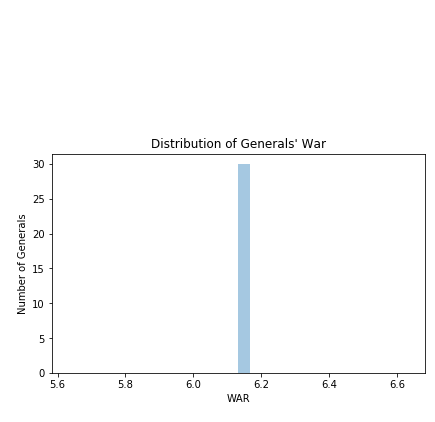

In [82]:
sns.distplot(df_totalwar['WAR'], kde = True, bins = 30)
plt.title("Distribution of Generals' War")
plt.ylabel('Number of Generals')
plt.annotate('Napoleon', xy = (16.713, 1), xytext = (17.713, 400), arrowprops = dict(facecolor = 'black'))
plt.annotate('Julius Caesar', xy = (7.364545, 1), xytext = (8.364545, 400), arrowprops = dict(facecolor = 'black'))
plt.tight_layout()
plt.savefig('/home/ethanarsht/Downloads/distplot.png')

In [ ]:
def index():
    output_file('docs/index.html')
    source = ColumnDataSource(data = dict(battles = df_totalwar.Battles,
                                          war = df_totalwar.WAR,
                                          general = df_totalwar.General))

    hover = HoverTool(tooltips = [('General', '@general'),
                                  ('Battles', '@battles'),
                                  ('WAR', '@war'),
                                      ])
    p = figure(title = "Click a circle for a profile of that general's career WAR",
               plot_height = 600, 
               plot_width = 800,

               tools = [hover, "tap", 'box_zoom', ResetTool()])
    p.circle(x = 'war', y = 'battles', size = 10, source = source)
    p.xaxis.axis_label = 'WAR'
    p.yaxis.axis_label = 'Battles'

    link = "{}.html".format('@general')

    if link == 'https://ethanarsht.github.io/military_rankings/Thomas de Courtenay, 5th/13th Earl of Devon':
            link = 'https://ethanarsht.github.io/military_rankings/Thomas de Courtenay'
    url = link
    taptool = p.select(type=TapTool)
    taptool.callback = OpenURL(url=url)
    save(p)

In [ ]:
index()

In [ ]:
df_battles

In [80]:
import bokeh.models as bkm
import bokeh.plotting as bkp
from bokeh.transform import factor_cmap

In [107]:
def bokeh(commander):
    global df_battles
    
    df_battles = pd.DataFrame()
    commander_war(commander)
    
#     df_battles = df_battles[df_battles.General == commander]
    df_battles.Year = df_battles.Year.fillna(-5000)
    df_battles.Year = df_battles.Year.astype(float, errors = 'ignore')
    df_battles = df_battles.sort_values('Year')
    wl = pd.DataFrame(df_battles.Outcome.value_counts())
    
    if 'V' in wl.index:
        wins = wl.loc['V', 'Outcome']
    else:
        wins = 0
    if 'D' in wl.index:
        losses = wl.loc['D', 'Outcome']
    else:
        losses = 0
    if 'I' in wl.index:
        draws = wl.loc['I', 'Outcome']
    else:
        draws = 0
    df_battles = df_battles.reset_index(drop = True)
    for i, row in df_battles.iterrows():
        df_battles.ix[i, 'cumulative'] = sum(df_battles.Value[0:i+1])
    
    
    source = ColumnDataSource(data = dict(battle = df_battles.Battle,
                              general = df_battles.General,
                              outcome = df_battles.Outcome,
                              value = df_battles.Value,
                              year = df_battles.Year,
                              cumulative = df_battles.cumulative))
    if all(x != -5000 for x in df_battles.Year):
        hover = HoverTool(tooltips = [('Battle', '@battle'),
                                  ('Outcome', '@outcome'),
                                  ('WAR', '@value'),
                                  ('Cumulative WAR', '@cumulative'),
                                  ('Year', '@year')])
    else:
        hover = HoverTool(tooltips = [('Battle', '@battle'),
                                  ('Outcome', '@outcome'),
                                  ('WAR', '@value'),
                                  ('Cumulative WAR', '@cumulative')
                                  ])
    
    x = list(df_battles.Battle)
    y = list(df_battles.Value)
    y_cum = list(df_battles.cumulative)
    
    if commander == 'Thomas de Courtenay, 5th/13th Earl of Devon':
        commander = 'Thomas de Courtenay'
    
    output_file('/home/ethanarsht/Downloads/{}.html'.format(commander))
    
    p = figure(title = commander + ' ({} - {} - {})'.format(wins, draws, losses), 
               plot_width=800, 
               plot_height=600, 
               x_range = x, 
               tools = [hover, 'tap'])
    p.xaxis.axis_label = "Click on a bar for more info on the battle it represents"
    
    url = 'https://en.wikipedia.org/wiki/{}'.format('@battle')
    taptool = p.select(type=TapTool)
    taptool.callback = OpenURL(url=url)

    p.line(x = 'battle', y = 'cumulative', source = source, line_width = 5)
#     g1_r = p.add_glyph(source_or_glyph = source, glyph = g_2)
#     g1_tap = TapTool(renderers = [g1_r],
#                     callback = OpenURL(url=url))
#     p.add_tools(g1_tap)
    
    color_mapper = CategoricalColorMapper(factors=['V', 'D', 'I'], palette=['Blue', 'Red', 'Yellow'])
    p.vbar(x = 'battle', 
           top = 'value', 
           width = 0.9, 
           color={'field': 'outcome', 'transform': color_mapper},
           alpha = 0.5,
           source = source)
    
#     url_2 = 'en.wikipedia.org/wiki/@battle'
#     g2_r = p.add_glyph(source_or_glyph = source, glyph = g_2)
#     g2_tap = TapTool(renderers = [g2_r],
#                      callback = OpenURL(url=url_2))
#     p.add_tools(g2_tap)
    
    
    p.xaxis.major_label_orientation = math.pi/2
    

#     show(p)
    save(p)

In [108]:
battle_list = []
bokeh('Takeda Shingen')

   infantry_diff  cavalry_dfff  ships_diff  airforce_diff
0            0.0           0.0         0.0            0.0
6.07446356192


/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [109]:
count = 0
for general in df_run.belligerent.unique()[1:]:
    battle_list = []
    count += 1
    print(str(count) + '/' + str(len(df_run.belligerent.unique())))
    print(general)
    bokeh(general)

1/6620
David Ben-Gurion
0.970180090971
2/6620
Yisrael Galili
0.463551490103


/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


3/6620
Yaakov Dori
0.463551490103
4/6620
Yigael Yadin
0.463551490103
5/6620
Mickey Marcus
0.463551490103
6/6620
Yigal Allon
0.463551490103
7/6620
Yitzhak Rabin
1.0260582602
8/6620
David Shaltiel
0.463551490103
9/6620
Moshe Dayan
2.08530863877
10/6620
Shimon Avidan
0.463551490103
11/6620
Moshe Carmel
0.463551490103
12/6620
Yitzhak Sadeh
0.463551490103
13/6620
Abdul Rahman Hassan Azzam
-0.467497314778
14/6620
Farouk of Egypt
-0.467497314778
15/6620
Abdullah I of Jordan
-0.467497314778
16/6620
Muzahim al-Pachachi
-0.467497314778
17/6620
Husni al-Za'im
-0.467497314778
18/6620
Amin al-Husseini
-0.467497314778
19/6620
Ahmed Ali al-Mwawi
-0.467497314778
20/6620
Mohammed Naguib
-0.467497314778
21/6620
John Bagot Glubb
-0.467497314778
22/6620
Habis al-Majali
-0.467497314778
23/6620
Hasan Salama
-0.467497314778
24/6620
Arab Liberation Army
-0.467497314778
25/6620
Fawzi al-Qawuqji
-0.467497314778
26/6620
Menachem Begin
-0.0701761409029
27/6620
Ariel Sharon
2.14064344639
28/6620
Rafael Eitan
-0.07

213/6620
Asakura Yoshikage
-1.37829819476
214/6620
Timur
0.47269340711
215/6620
Shahrukh Mirza
0.47269340711
216/6620
Khalil Sultan
0.47269340711
217/6620
Miran Shah
0.47269340711
218/6620
Abu Bakr (Timurid)
0.47269340711
219/6620
Sultan Huseyn
0.47269340711
220/6620
Pir Muhammad ibn Jahangir
0.47269340711
221/6620
Taj al-Din Shah-i Shahan Abu'l Fath
0.47269340711
222/6620
Bayezid I
-0.022667332018
223/6620
Süleyman Çelebi
-0.476647906487
224/6620
Mehmed I
-0.476647906487
225/6620
Stefan Lazarević
0.0030790232088
226/6620
Gannys
0.5
227/6620
Heraclius
-0.688106718508
228/6620
Shahrbaraz
0.422004140888
229/6620
Shahin Vahmanzadegan
0.5
230/6620
Eslamu
-0.58490276267
231/6620
Fatagar
-0.58490276267
232/6620
Theophilos (emperor)
-0.515504824239
233/6620
Theophobos
-0.515504824239
234/6620
Manuel the Armenian
-0.515504824239
235/6620
Khaydhar ibn Kawus al-Afshin
0.511543050701
236/6620
Umar al-Aqta
0.511543050701
237/6620
Jaysh ibn Samsama
0.5
238/6620
Damian Dalassenos
-0.5
239/6620
Teuto

0.0295472345903
418/6620
John Stewart, Earl of Buchan
-0.62193851075
419/6620
Gilbert Motier de La Fayette
0.442430015083
420/6620
List of Marshals of France
0.442430015083
421/6620
Thomas of Lancaster, 1st Duke of Clarence
-0.446345642006
422/6620
Thomas Beaufort, Duke of Exeter
-0.446345642006
423/6620
John Beaufort, 1st Duke of Somerset
-0.446345642006
424/6620
Zhang Fei
1.04970813252
425/6620
Zhang He
-0.0290421941119
426/6620
Baldwin IV of Jerusalem
0.0462829856301
427/6620
Baldwin of Ibelin
0
428/6620
Balian of Ibelin
-0.97220610767
429/6620
Hugh II of Saint Omer
0
430/6620
Gökböri
0.882927783741
431/6620
Charles I of Naples
0.5
432/6620
Manfred, King of Sicily
-0.5
433/6620
Quintus Fulvius Flaccus (consul 237 BC)
-0.0526332364033
434/6620
Hanno the Elder
-0.985929095138
435/6620
Tiberius Sempronius Gracchus (consul 215 BC)
0.498590642191
436/6620
Manius Curius Dentatus
0.5
437/6620
John II Komnenos
0.5
438/6620
Telerig of Bulgaria
-0.425877070512
439/6620
Seron (Syrian governor)

614/6620
Nebuchadnezzar II
2.0372867463
615/6620
Marcus Licinius Crassus
-0.491309714015
616/6620
Publius Licinius Crassus (son of triumvir)
-0.491309714015
617/6620
Gaius Cassius Longinus
-1.47357605923
618/6620
Surena
0.487346846031
619/6620
Hasan ibn al-Nu'man
0.5
620/6620
Tiberios III
-0.5
621/6620
Hasdrubal the Boetharch
-0.5
622/6620
Scipio Aemilianus
1.0
623/6620
Manius Manilius
0.5
624/6620
Alberico da Barbiano
0.5
625/6620
Muzio Sforza
-0.0284865125214
626/6620
Galeotto I Malatesta
0.45921704106
627/6620
John Hawkwood
0.0584169785512
628/6620
Hanneken von Baumgarten
-0.463157824993
629/6620
Azzo VII d'Este
0.5
630/6620
Ezzelino III da Romano
-0.5
631/6620
Nicolaas Zannekin
-0.501982337045
632/6620
Philip VI of France
0.498017662955
633/6620
Giovanni Ordelaffi
-0.525530680175
634/6620
Da Polenta family
-0.525530680175
635/6620
Giovanni dell'Ischia
-0.525530680175
636/6620
Francesco Novello da Carrara
0.521574803544
637/6620
Jean Bureau
0.494875091263
638/6620
John Talbot, 1st E

822/6620
Tughril
0.551263481056
823/6620
Faramurz
0.551263481056
824/6620
Minamoto no Yoshitsune
1.55058023402
825/6620
Taira no Munemori
-1.03060493504
826/6620
Taira no Tomomori
-0.0306049350383
827/6620
Perozes
-0.536487518685
828/6620
Pityaxes
-0.536487518685
829/6620
Baresmanas
-0.536487518685
830/6620
Pharas the Herulian
0.532541736714
831/6620
Taddeo d'Este
-0.5
832/6620
Niccolò Piccinino
1.0
833/6620
William the Silent
-1.065185223
834/6620
Thomas Morgan (died 1595)
0.986648399129
835/6620
Francisco de Valdez
-0.999179165
836/6620
Julian Romero
0.0117777600968
837/6620
Pagondas
0.490041243169
838/6620
Hippocrates of Athens
-0.494004908133
839/6620
Alexios Doukas Philanthropenos
0.473512875605
840/6620
John Palaiologos (brother of Michael VIII)
-0.628019542488
841/6620
Fillippo Sanudo
-0.47746802294
842/6620
Guglielmo II da Verona
-0.47746802294
843/6620
Publius Cornelius Scipio
-0.507929847572
844/6620
Chen Tai
0.442430015083
845/6620
Deng Ai
0.442430015083
846/6620
Hu Fen
0.44

0.513511325562
1015/6620
Francisco Verdugo
0.513511325562
1016/6620
John FitzAlan, 14th Earl of Arundel
-0.570646803673
1017/6620
La Hire
1.12041134099
1018/6620
Jean Poton de Xaintrailles
1.12041134099
1019/6620
Marcus Minucius Rufus
-0.467458263286
1020/6620
Magister equitum
-0.467458263286
1021/6620
Archibald Campbell, 7th Earl of Argyll
-0.570646803673
1022/6620
George Gordon, 1st Marquess of Huntly
0.566756982993
1023/6620
Francis Hay, 9th Earl of Erroll
0.566756982993
1024/6620
Máel Sechnaill mac Domnaill
0.5
1025/6620
Sorley Boy MacDonnell
-0.5
1026/6620
Joseph Kabila
0.442430015083
1027/6620
Babacar Gaye
0.442430015083
1028/6620
Ignace Murwanashyaka
0.442430015083
1029/6620
José Eduardo dos Santos
0.442430015083
1030/6620
Robert Mugabe
0.442430015083
1031/6620
Laurent Nkunda
-0.446345642006
1032/6620
Lamoral, Count of Egmont
0.93216666029
1033/6620
Paul de Thermes
-0.485482075832
1034/6620
Gaius Claudius Nero
0.963732464907
1035/6620
Ulrich von Jungingen
-0.527457265982
1036/66

1208/6620
Han Dang
0.549708132522
1209/6620
Lü Meng
0.549708132522
1210/6620
Ling Tong
0.549708132522
1211/6620
Zhou Tai
0.549708132522
1212/6620
Gan Ning
0.549708132522
1213/6620
Lei Xu
0.549708132522
1214/6620
Yuan Shao
0.981225854729
1215/6620
Qu Yi
0.483208191773
1216/6620
Tian Feng
0.483208191773
1217/6620
Gongsun Zan
-0.9891517239
1218/6620
Yan Gang
-0.487169386855
1219/6620
Ma Su
-0.467458263286
1220/6620
Wang Ping (Three Kingdoms)
0.0325417367142
1221/6620
Zhang Han (Qin dynasty)
-0.560654767057
1222/6620
Sima Xin
-0.560654767057
1223/6620
Dong Yi (Qin dynasty)
-0.560654767057
1224/6620
Ying Bu
0.556744737505
1225/6620
Zhongli Mo
0.556744737505
1226/6620
Zheng Ji (general)
-0.5
1227/6620
Muwatalli II
-0.532224739627
1228/6620
Ḫattušili III
-0.532224739627
1229/6620
Mitanni
-0.532224739627
1230/6620
Ramesses II
1.02827457713
1231/6620
Paser (vizier)
0.528274577135
1232/6620
Amun-her-khepeshef
0.528274577135
1233/6620
Ramesses (prince)
0.528274577135
1234/6620
Khaemweset
0.528274

0.5
1404/6620
Cleombrotus I
-0.521390770045
1405/6620
Epaminondas
0.517432071657
1406/6620
Constantine Dalassenos (thalassokrator)
0.5
1407/6620
Henry III of England
-1.13436749332
1408/6620
Richard, 1st Earl of Cornwall
-0.536487518685
1409/6620
Nicholas de Segrave, 1st Baron Segrave
0.532541736714
1410/6620
Swedish jarls
-0.5
1411/6620
Charles the Deaf
-0.5
1412/6620
Juan Adolf van Haamstede
-0.5
1413/6620
Lodewijk van Boisot
1.00935720215
1414/6620
Ulrich II von Rosenberg
0.483089800175
1415/6620
Prokop the Great
0.0196088564504
1416/6620
Jan Čapek ze Sán
-0.487050939403
1417/6620
Prokop the Lesser
-0.487050939403
1418/6620
Jan Roháč z Dubé
0.0196088564504
1419/6620
Ahmed Khan bin Küchük
-0.5
1420/6620
James Douglas, 9th Earl of Douglas
-0.5
1421/6620
Alexander Stewart, Duke of Albany
-0.5
1422/6620
Simeon Bekbulatovich
-0.589143313034
1423/6620
Clas Åkesson Tott
0.58529928669
1424/6620
Robert Welles, 8th Baron Willoughby de Eresby
-0.5
1425/6620
Zhao Ponu
0.5
1426/6620
Henry VI of 

0.57230966704
1598/6620
Bouchard de Marly
0.57230966704
1599/6620
Guillaume des Barres
0.57230966704
1600/6620
Guillaume de Contres
0.57230966704
1601/6620
Jean de Clamorgan
-0.533389661402
1602/6620
Álvaro de Bazán the Elder
0.529440638689
1603/6620
Constantius II
0.47075883522
1604/6620
Magnentius
-0.474711720324
1605/6620
Andrew Mackay (British Army officer)
0.5
1606/6620
Mahayadin Ghori
0.5
1607/6620
Shurahbil ibn Amr
0.442430015083
1608/6620
Zayd ibn Harithah
-0.446345642006
1609/6620
Ja'far ibn Abi Talib
-0.446345642006
1610/6620
'Abd Allah ibn Rawahah
-0.446345642006
1611/6620
King Zhou of Shang
-0.513502446602
1612/6620
King Wu of Zhou
0.509539877584
1613/6620
Artayntes
-0.558284387997
1614/6620
Mardontes
-0.558284387997
1615/6620
Tigranes (general)
-0.558284387997
1616/6620
Leotychidas
0.554370030438
1617/6620
Perilaus (general)
0.554370030438
1618/6620
Kurushima Michifusa
-0.617021700363
1619/6620
Mōri Takamasa
-0.617021700363
1620/6620
Kan Michinaga
-0.617021700363
1621/6620

1800/6620
Krum
1.54046653403
1801/6620
John II of France
-0.532439787579
1802/6620
Philip the Bold
-0.0413352260525
1803/6620
Charles V of France
-0.532439787579
1804/6620
Peter I, Duke of Bourbon
-0.532439787579
1805/6620
Walter VI, Count of Brienne
-0.532439787579
1806/6620
Jean de Clermont
-0.532439787579
1807/6620
Philip, Duke of Orléans
-0.532439787579
1808/6620
William Douglas, 1st Earl of Douglas
-0.532439787579
1809/6620
Edward, the Black Prince
0.528489832249
1810/6620
Thomas de Beauchamp, 11th Earl of Warwick
0.528489832249
1811/6620
William de Montagu, 2nd Earl of Salisbury
0.528489832249
1812/6620
Ippolito d'Este
0.5
1813/6620
Alfonso I d'Este, Duke of Ferrara
0.979414599962
1814/6620
Angelo Trevisan
-0.5
1815/6620
Olivier de Clisson
0.989122224481
1816/6620
Robert Knolles
-0.501982337045
1817/6620
Alfonso V of Aragon
-0.577262833137
1818/6620
John II of Aragon and Navarre
-0.577262833137
1819/6620
Henry, Duke of Villena
-0.577262833137
1820/6620
Filippo Maria Visconti
1.06

-0.573250975571
1992/6620
Thomas Wharton, 1st Baron Wharton
0.569366943682
1993/6620
Hubert de Burgh, 1st Earl of Kent
0.416483766466
1994/6620
Philip d'Aubigny
0.416483766466
1995/6620
Robert I, Latin Emperor
-0.420342877335
1996/6620
Eustace the Monk
-0.420342877335
1997/6620
Xenophon (son of Euripides)
-0.5
1998/6620
Lembitu
-1.09465972037
1999/6620
Caupo of Turaida
1.09083146081
2000/6620
Bernard II, Lord of Lippe
0.590831460809
2001/6620
Emmanuel Philibert, Duke of Savoy
0.450644941942
2002/6620
Louis Gonzaga, Duke of Nevers
-0.454573999029
2003/6620
Al-Husayn ibn Rabah
-0.428879125561
2004/6620
Preljub
0.5
2005/6620
Kálfr Árnason
0.459584993442
2006/6620
Thorir Hund
0.459584993442
2007/6620
Hárek of Tjøtta
0.459584993442
2008/6620
Olaf II of Norway
-0.463526228471
2009/6620
Dag Ringsson
-0.463526228471
2010/6620
Hugh de Cressingham
-0.530076780855
2011/6620
Andrew Moray
0.526124629775
2012/6620
George Talbot, 4th Earl of Shrewsbury
0.47729119698
2013/6620
George Stanley, 9th Baro

2188/6620
Henry of Flanders
0.5
2189/6620
Theodore I Laskaris
-0.5
2190/6620
Boduognatus
-0.531193447328
2191/6620
Lord Lovat
0
2192/6620
Marcus Centenius Penula
-0.474586561412
2193/6620
Claude d'Annebault
-0.106203998084
2194/6620
John Dudley, 1st Duke of Northumberland
0.102411871509
2195/6620
David I of Scotland
-0.525892345199
2196/6620
William le Gros, 1st Earl of Albemarle
0.521936740926
2197/6620
Sviatopolk II of Kiev
-0.5
2198/6620
Vladimir II Monomakh
-0.5
2199/6620
Rostislav Vsevolodovich
-0.5
2200/6620
Vishvamitra
-0.5
2201/6620
Sudas
0.5
2202/6620
Vashistha
0.5
2203/6620
Arminius
-0.00692049812108
2204/6620
Publius Quinctilius Varus
-0.497043789211
2205/6620
Suicide
-0.497043789211
2206/6620
Jean de Beaumanoir
0.498017662955
2207/6620
Robert Bemborough
-0.501982337045
2208/6620
Tiberius Sempronius Longus (consul 218 BC)
-0.504291231043
2209/6620
Abu Sufyan ibn Harb
-0.645745699864
2210/6620
Uthman
0.553654357994
2211/6620
Salman the Persian
0.553654357994
2212/6620
Arnegis

0.471239423606
2386/6620
Geoffrey I of Vianden
0.471239423606
2387/6620
Siegfried II of Westerburg
-0.475192720825
2388/6620
Reginald I of Guelders
-0.475192720825
2389/6620
Henry VI, Count of Luxembourg
-0.475192720825
2390/6620
Waleran I, Lord of Ligny
-0.475192720825
2391/6620
Adolf of Germany
-0.475192720825
2392/6620
Dietrich Luf II
-0.475192720825
2393/6620
Sima Yi
-0.0364875186852
2394/6620
Guo Huai
-0.536487518685
2395/6620
Fei Yi
0.532541736714
2396/6620
Wei Yan
0.0325417367142
2397/6620
Yang Yi
0.0325417367142
2398/6620
Huang Zu
-0.0754799006935
2399/6620
Ling Cao
0.0716009948842
2400/6620
Aju
0.410641730987
2401/6620
Arikhgiya
0.410641730987
2402/6620
Shi Tianze
0.410641730987
2403/6620
Lü Wenhuan
-0.414485161102
2404/6620
Li Tingzhi
-0.414485161102
2405/6620
Shamoke
-0.490460122416
2406/6620
Cao Shuang
-0.5
2407/6620
Xu Rong (general)
0.498017662955
2408/6620
Oda Nobutaka
0.457121428383
2409/6620
Nakamura Kazuuji
0.457121428383
2410/6620
Horio Yoshiharu
0.457121428383
2411/

2582/6620
Melancton Smith (1810–1893)
-0.0667204427251
2583/6620
James W. Cooke
0.0628223021392
2584/6620
Mårten Anckarhielm
-0.486063238573
2585/6620
Antonio de Oquendo
0.0311422454963
2586/6620
William Beresford, 1st Viscount Beresford
-0.0239780668226
2587/6620
Joaquín Blake
-1.57298030837
2588/6620
Jean-de-Dieu Soult
-3.45274293318
2589/6620
Jean-Baptiste Girard (soldier)
-0.461227987882
2590/6620
Jean-Baptiste Jourdan
1.40986987727
2591/6620
François Sébastien Charles Joseph de Croix, Count of Clerfayt
-2.3957095259
2592/6620
Hugh Judson Kilpatrick
0.467944713327
2593/6620
Thomas T. Munford
0.926594304572
2594/6620
George Gordon, 2nd Marquess of Huntly
0.506318933957
2595/6620
Manus O'Cahan's Regiment
1.05512517348
2596/6620
William Baillie (soldier)
-1.09997693244
2597/6620
Alexander Lindsay, 1st Earl of Balcarres
-0.510282515333
2598/6620
Sardar
-0.0808137387477
2599/6620
Ranjodh Singh Majithia
-1.05296120448
2600/6620
Sir Harry Smith, 1st Baronet
0.979881206678
2601/6620
Prince

2758/6620
王孝祺 - 维基百科，自由的百科全书
0.451033986898
2759/6620
蘇元春 - 维基百科，自由的百科全书
0.451033986898
2760/6620
陈嘉 - 维基百科，自由的百科全书
0.451033986898
2761/6620
蔣宗汉 - 维基百科，自由的百科全书
0.451033986898
2762/6620
魏刚 - 维基百科，自由的百科全书
0.451033986898
2763/6620
Oscar de Négrier
-0.454963626803
2764/6620
François Louis de Rousselet, Marquis de Châteaurenault
0.479945063569
2765/6620
Arthur Herbert, 1st Earl of Torrington
-0.966529839586
2766/6620
Manuel Lapeña
-0.0278013153665
2767/6620
Thomas Graham, 1st Baron Lynedoch
0.949343485436
2768/6620
Claude Victor-Perrin, Duc de Belluno
-1.47323832952
2769/6620
Jacques MacDonald
-1.53369374213
2770/6620
Khem Karan Singh
0.965169007412
2771/6620
Arun Shridhar Vaidya
0.498017662955
2772/6620
Abdul Ali Malik
-0.973083238904
2773/6620
Dagobert Sigmund von Wurmser
-0.964457170869
2774/6620
Jonathan M. Wainwright (general)
-1.45775672643
2775/6620
George M. Parker (general)
-0.525892345199
2776/6620
Edward P. King
-0.525892345199
2777/6620
Vicente Lim
-1.02836798493
2778/6620
Masah

2939/6620
Claes Uggla
-0.0384943977112
2940/6620
Johan Bär
-0.0384943977112
2941/6620
Eugène de Beauharnais
-0.500457346661
2942/6620
Pyotr Bagration
-0.997050814663
2943/6620
Michael Andreas Barclay de Tolly
-1.15325140796
2944/6620
James Lawrence
-0.509148902844
2945/6620
Philip Broke
0.505185043357
2946/6620
Robert Hamilton of Preston
-0.511408589318
2947/6620
James Scott, 1st Duke of Monmouth
-0.00934648365331
2948/6620
John Graham, 1st Viscount Dundee
0.507445324573
2949/6620
Jacques François Dugommier
1.48865762159
2950/6620
Luis Firmín de Carvajal, Conde de la Unión
-1.01773657473
2951/6620
John Forbes (Portuguese general)
-1.01773657473
2952/6620
Winfield Scott Hancock
-0.549367484094
2953/6620
Henry Heth
0.00498333265645
2954/6620
William Howe, 5th Viscount Howe
2.78200974206
2955/6620
Wilhelm von Knyphausen
0.439446787684
2956/6620
George Washington
-0.110165287421
2957/6620
Nathanael Greene
-1.02864404994
2958/6620
John Sullivan (general)
-1.02631018379
2959/6620
William Ale

3113/6620
Luigi Capello
0.953751314994
3114/6620
Svetozar Boroević
-1.37944210934
3115/6620
Johann Ritter von Henriquez
-0.457684891497
3116/6620
Otto von Below
-0.457684891497
3117/6620
Miguel de la Torre
-0.508082257851
3118/6620
Simón Bolívar
0.504118173914
3119/6620
José Antonio Páez
0.504118173914
3120/6620
Thomas Mahon, 2nd Baron Hartland
0.5
3121/6620
William Rosecrans
1.84599167943
3122/6620
John B. Floyd
-0.474814656211
3123/6620
Henry Osborn (Royal Navy officer)
0.403699326467
3124/6620
Michel-Ange Duquesne de Menneville
-0.407522708849
3125/6620
Edward Vernon
-0.582388986659
3126/6620
Thomas Wentworth (British Army officer)
-0.582388986659
3127/6620
Blas de Lezo
0.578526975201
3128/6620
Sebastián de Eslava
0.578526975201
3129/6620
Campuzano Polanco family
0.578526975201
3130/6620
Carlos Desnaux
0.578526975201
3131/6620
Claiborne Fox Jackson
0.439345232943
3132/6620
Franz Sigel
-1.42963728938
3133/6620
Philippe I, Duke of Orléans
0.494875091263
3134/6620
Louis de Crevant, Duk

-1.51134440202
3300/6620
Charles I of England
-0.400901359959
3301/6620
John C. Frémont
-0.984826487931
3302/6620
James Wilkinson
-0.083916149262
3303/6620
John Parker Boyd
-0.583916149262
3304/6620
Leonard Covington
-0.583916149262
3305/6620
William Mulcaster
0.580058077164
3306/6620
Joseph Wanton Morrison
1.06655563056
3307/6620
Nureddin Pasha
0.482138828015
3308/6620
Charles Vere Ferrers Townshend
-0.490056297181
3309/6620
George Pocock
-0.00198233704484
3310/6620
Anne Antoine, Comte d'Aché
-0.00198233704484
3311/6620
Edward Hughes (Royal Navy officer)
-1.52233552801
3312/6620
Pierre André de Suffren
1.96955677739
3313/6620
Prince William, Duke of Cumberland
-0.967878378115
3314/6620
Charles Edward Stuart
0.489732801841
3315/6620
Thomas L. Rosser
0.00770861402609
3316/6620
Andrew A. Humphreys
-0.0342238860611
3317/6620
John Irvin Gregg
-0.501982337045
3318/6620
Bartolomé Mitre
-0.563857973398
3319/6620
Joaquim Marques Lisboa, Marquis of Tamandaré
-0.563857973398
3320/6620
José E. Dí

3477/6620
Juan Ibarrola
-0.426109194879
3478/6620
Francisco Galán Rodríguez
-0.426109194879
3479/6620
Muhammad Ahmad
0.856603275693
3480/6620
William Hicks (British soldier)
-0.440045923583
3481/6620
Jan Smuts
0.5
3482/6620
John French, 1st Earl of Ypres
1.33400192332
3483/6620
Ian Standish Monteith Hamilton
-0.0836480995738
3484/6620
Adolf Schiel
-0.444593902112
3485/6620
Johann Sigismund Riesch
-0.498839608726
3486/6620
Mouha ou Hammou Zayani
0.43561808506
3487/6620
René Laverdure
-0.439520947889
3488/6620
William F. Lynch
-0.449360181141
3489/6620
Stephen Clegg Rowan
0.895228641395
3490/6620
Frederick Steele
1.85059096217
3491/6620
William B. Franklin
0.472114056364
3492/6620
Gustavus Woodson Smith
-0.509671942072
3493/6620
William H.C. Whiting
-0.494866060712
3494/6620
Sentarō Ōmori
-0.488956463899
3495/6620
Matsuji Ijuin
-0.498394828368
3496/6620
Yoshimi Nishida
-0.929105237809
3497/6620
Harry W. Hill
0.905292353157
3498/6620
John T. Walker (USMC)
0.5
3499/6620
Thomas E. Watson (U

3657/6620
Otto Liman von Sanders
0.565549596514
3658/6620
Enver Pasha
1.02173590653
3659/6620
Cevat Çobanlı
0.565549596514
3660/6620
Wehib Pasha
0.0305902180177
3661/6620
Yakup Şevki Subaşı
0.0406458798078
3662/6620
Kâzım Karabekir
0.0693144652136
3663/6620
Desta Damtew
-0.511408589318
3664/6620
Afawarq Walda Samayat
-0.511408589318
3665/6620
Beyene Merid
-0.511408589318
3666/6620
Rodolfo Graziani
0.99326555146
3667/6620
Pietro Maletti
0.507445324573
3668/6620
Olol Dinle
0.507445324573
3669/6620
Gustaf Wattrang
-0.384886257317
3670/6620
Nils Ehrenskiöld
-0.384886257317
3671/6620
Fyodor Apraksin
0.381138629971
3672/6620
Matija Zmajević
0.381138629971
3673/6620
Javad Khan
-0.5
3674/6620
Pavel Tsitsianov
0.5
3675/6620
Flight lieutenant
-0.5
3676/6620
Pervaiz Mehdi Qureshi
-0.5
3677/6620
William Farrar Smith
0
3678/6620
Robert Toombs
0
3679/6620
George T. Anderson
0
3680/6620
Claude Auchinleck
-0.0695769740601
3681/6620
Neil Ritchie
-0.519001538159
3682/6620
Ettore Bastico
0.0455452993975


3847/6620
Archduke John of Austria
-0.013728788195
3848/6620
Alexander Danilovich Menshikov
-0.119649181462
3849/6620
Anikita Repnin
-0.541577765465
3850/6620
Charles XII of Sweden
0.586044730677
3851/6620
Andranik
0.5
3852/6620
Kevork Chavush
0.5
3853/6620
Jean Nicolas Houchard
0.472118992851
3854/6620
Wilhelm von Freytag
-0.476073025324
3855/6620
Takashi Sakai
0.364923643637
3856/6620
Tadamichi Kuribayashi
-0.0667625194014
3857/6620
Mark Aitchison Young
-0.368606797866
3858/6620
Christopher Maltby
-0.368606797866
3859/6620
John K. Lawson
-0.368606797866
3860/6620
Voldemar Oinonen
-0.5
3861/6620
Francisco de Melo
-0.0490461867318
3862/6620
Antoine III de Gramont
-0.462637372324
3863/6620
Andrew Jackson
1.89522260555
3864/6620
Menawa
-0.456002902551
3865/6620
Joseph Lane
0.987509993585
3866/6620
Juan José Castelli
-0.541773377859
3867/6620
Antonio González de Balcarce
-0.541773377859
3868/6620
José Manuel de Goyeneche, 1st Count of Guaqui
0.537833829521
3869/6620
Wolmar Anton von Schli

4031/6620
James Johnston (Colonel)
0.508620609419
4032/6620
William Campbell (general)
0.508620609419
4033/6620
John Sevier
0.508620609419
4034/6620
Frederick Hambright
0.508620609419
4035/6620
Joseph McDowell, Jr.
0.508620609419
4036/6620
Benjamin Cleveland
0.508620609419
4037/6620
James Williams (Revolutionary War)
0.508620609419
4038/6620
Isaac Shelby
0.508620609419
4039/6620
Joseph Winston
0.508620609419
4040/6620
John G. Foster
0.350950317451
4041/6620
Charles IX of Sweden
-0.582307256641
4042/6620
Hetmans of the Polish–Lithuanian Commonwealth
0.0419575177666
4043/6620
Radko Dimitriev
0.982840444365
4044/6620
Ivan Fichev
0.982840444365
4045/6620
Mahmud Muhtar Pasha
-0.479193138922
4046/6620
Joseph C. Porter
-0.546296687902
4047/6620
Arshak Ter-Gukasov
-0.506491132551
4048/6620
Ahmed Muhtar Pasha
-1.68240689684
4049/6620
Augustus II the Strong
-0.517762016555
4050/6620
Adam Heinrich von Steinau
-0.517762016555
4051/6620
Hieronim Augustyn Lubomirski
-0.517762016555
4052/6620
Frederi

0.938721280342
4214/6620
Thomas Moonlight
-0.438099821357
4215/6620
Barthélemy Louis Joseph Schérer
0.481143504016
4216/6620
Olivier, Count of Wallis
-0.485103661264
4217/6620
Prince Benedetto, Duke of Chablais
-0.485103661264
4218/6620
Maximilian Ulysses Browne
-0.415270422954
4219/6620
Johann Peter Beaulieu
-0.477107856046
4220/6620
Karl Philipp Sebottendorf
-0.477107856046
4221/6620
Luís Alves de Lima e Silva, Duke of Caxias
0.422693205367
4222/6620
Francisco Solano López
-0.426567791769
4223/6620
Jeremiah V. Cockrell
0.402686397357
4224/6620
Emory S. Foster
-0.406506726324
4225/6620
Harold Bridgwood Walker
0.5
4226/6620
Sir William Erskine, 1st Baronet
0.463512481315
4227/6620
Charles Mawhood
0.0213134587534
4228/6620
Thomas Mifflin
-0.467458263286
4229/6620
Henry Knox
0.00608646756863
4230/6620
Harry Smith (Australian soldier)
0.5
4231/6620
Kuldip Singh Chandpuri
0.5
4232/6620
Guy Carleton, 1st Baron Dorchester
0.934098118949
4233/6620
Ethan Allen
0.00444971176731
4234/6620
James 

0.5
4389/6620
Johann von Hanxleden
0.5
4390/6620
David Farragut
0.35211466015
4391/6620
Union Navy
0.35211466015
4392/6620
Gordon Granger
0.85211466015
4393/6620
Union Army
0.35211466015
4394/6620
Confederate States Navy
-0.355740951007
4395/6620
Richard Lucian Page
-0.355740951007
4396/6620
Confederate States Army
-0.355740951007
4397/6620
Mohamed Farrah Aidid
-0.597977375213
4398/6620
William F. Garrison
0.594159064879
4399/6620
William J. Worth
0.454554968717
4400/6620
Francisco Pérez (general)
-0.458489664503
4401/6620
Lucas Balderas
-0.458489664503
4402/6620
Kurt Christoph Graf von Schwerin
0.491376951976
4403/6620
Charles Lee (general)
0.0122499677848
4404/6620
Gilbert du Motier, Marquis de Lafayette
0.473544730854
4405/6620
Lew Wallace
-0.459122993755
4406/6620
Alexander von Kluck
-0.0187716911985
4407/6620
Justo José de Urquiza
0.490534524569
4408/6620
Manuel Marques de Sousa, Count of Porto Alegre
0.490534524569
4409/6620
Juan Manuel de Rosas
-0.494498310494
4410/6620
Harold A

4572/6620
James Shirk
-0.435570080673
4573/6620
Charles King (general)
1.0
4574/6620
Emīls Vītols
-0.530419665759
4575/6620
Hans Kalm
0.526467822294
4576/6620
Julius Kuperjanov
0.526467822294
4577/6620
Friedrich Zobel
-0.481249056042
4578/6620
John Salmon Ford
-0.5
4579/6620
Mariano Arista
-1.07025027654
4580/6620
Guipago
-1.06068467737
4581/6620
Ranald S. Mackenzie
0.951720975054
4582/6620
Luis Fery
-0.501982337045
4583/6620
Juan Williams Rebolledo
0.498017662955
4584/6620
Jeremiah C. Sullivan
-0.527881007149
4585/6620
Herbert Plumer, 1st Viscount Plumer
0.516313703379
4586/6620
François Anthoine
0.516313703379
4587/6620
Louis Ruquoy
0.516313703379
4588/6620
Henry Lee III
0.488591410682
4589/6620
William Sutherland (British Army officer)
-0.492554675427
4590/6620
Earl Van Dorn
-1.49586738669
4591/6620
William H. Rupertus
0.433379143643
4592/6620
Herman H. Hanneken
0.433379143643
4593/6620
Harold D. Harris
0.433379143643
4594/6620
Chesty Puller
0.433379143643
4595/6620
Kunio Nakagawa
-

4750/6620
Herbert Alexander Lawrence
0.504931522382
4751/6620
Dabulamanzi kaMpande
-1.13155488476
4752/6620
John Chard
0.596194702651
4753/6620
Gonville Bromhead
0.596194702651
4754/6620
Charles, Prince of Soubise
-1.0530388369
4755/6620
Prince Joseph of Saxe-Hildburghausen
-0.534337725996
4756/6620
Petre Dumitrescu
-0.983274469356
4757/6620
Dmitry Ryabyshev
0.5
4758/6620
Yakov Cherevichenko
0.5
4759/6620
Anton Lopatin
0.5
4760/6620
Vladimir Kolpakchi
0.5
4761/6620
P. W. Scharroo
-0.579095327274
4762/6620
Arthur Haselrig
-0.500578181122
4763/6620
Stephen Dodson Ramseur
-0.519410627015
4764/6620
Charles Bonaventure de Longueval, Count of Bucquoy
0.943700292441
4765/6620
Jean Reynier
0.0671539604758
4766/6620
Sir William Erskine, 2nd Baronet
0.501678014952
4767/6620
Graham N. Fitch
0.5
4768/6620
Augustus Kilty
0.5
4769/6620
Köprülüzade Fazıl Ahmed Pasha
-0.56236444112
4770/6620
Raimondo Montecuccoli
0.125619933475
4771/6620
Johann von Sporck
0.558457644146
4772/6620
Leopold Wilhelm, Marg

4934/6620
Nikita Khrushchev
0.479315344002
4935/6620
Vasily Chuikov
0.479315344002
4936/6620
Friedrich Paulus
0.0552990091643
4937/6620
Wolfram Freiherr von Richthofen
-0.483274469356
4938/6620
Constantin Constantinescu-Claps
-0.483274469356
4939/6620
Italo Gariboldi
-0.483274469356
4940/6620
Gusztáv Jány
-0.483274469356
4941/6620
Viktor Pavičić
-0.483274469356
4942/6620
Hermann von François
0.0665271844904
4943/6620
Velip Pasha
-0.521886253313
4944/6620
Burkhard Christoph von Münnich
0.51792786398
4945/6620
Claude Lecourbe
0.490041243169
4946/6620
Paul Kray
-0.494004908133
4947/6620
Józef Dwernicki
0.486497553398
4948/6620
John Chandler
-0.569820266193
4949/6620
John Harvey (British Army officer)
0.56592865333
4950/6620
Henry Johnson (American Revolutionary War)
-0.467458263286
4951/6620
Carl Gustaf Armfeldt
-1.0250282482
4952/6620
William Forbes Gatacre
-0.5
4953/6620
Avraham Adan
0.589062438626
4954/6620
Yossi Yoffe
0.5
4955/6620
Nahum Zaken
0.5
4956/6620
John J. Peck
0.006426253771

5129/6620
Charles Saunders (Royal Navy officer)
0.484726195152
5130/6620
George Townshend, 1st Marquess Townshend
0.484726195152
5131/6620
Louis Antoine de Bougainville
-0.984439887111
5132/6620
Louis Du Pont Duchambon de Vergor
-0.48868806696
5133/6620
Charles Michel de Langlade
0.0512143293929
5134/6620
Jean-Baptiste Nicolas Roch de Ramezay
-0.48868806696
5135/6620
Ibrahim Bey (Mamluk)
-0.521723034751
5136/6620
Lachlan McIntosh
-1.12028137765
5137/6620
Hans Langsdorff
-0.430777527333
5138/6620
Henry Harwood
0.426893169383
5139/6620
Plenty Coups
-0.498141228364
5140/6620
Washakie
-0.498141228364
5141/6620
Alexander William Doniphan
0.5
5142/6620
Gustav-Adolf von Zangen
-0.0227088030199
5143/6620
Harry Crerar
0.518750943958
5144/6620
Guy Simonds
0.518750943958
5145/6620
Bertram Ramsay
0.981085269532
5146/6620
Francisco de Moncada, 3rd Marquis of Aitona
-0.546322930551
5147/6620
John VIII, Count of Nassau-Siegen
-0.546322930551
5148/6620
Marinus Hollare
0.542389458489
5149/6620
Emir Abd

5303/6620
Settimio Piacentini
-0.525892345199
5304/6620
Enrico Gotti
-0.525892345199
5305/6620
Qazim Koculi
0.521936740926
5306/6620
Ahmet Lepenica
0.521936740926
5307/6620
Selam Musai
0.521936740926
5308/6620
Života Panić
0.405340279627
5309/6620
Mile Mrkšić
-0.0371851617261
5310/6620
Veselin Šljivančanin
0.405340279627
5311/6620
Mladen Bratić
0.405340279627
5312/6620
Goran Hadžić
0.405340279627
5313/6620
Arkan
-0.0882334666014
5314/6620
Vojislav Šešelj
0.405340279627
5315/6620
Blago Zadro
-0.409168539191
5316/6620
Mile Dedaković
-0.409168539191
5317/6620
Marko Babić (soldier)
-0.409168539191
5318/6620
Anton Tus
-0.409168539191
5319/6620
Talk:Battle of Vyazma
-0.519121988014
5320/6620
Shigematsu Sakaibara
0.423461679899
5321/6620
Eiji Gotō
0.423461679899
5322/6620
Tamon Yamaguchi
0.423461679899
5323/6620
Winfield S. Cunningham
-0.427338096185
5324/6620
James Devereux
-0.427338096185
5325/6620
Paul A. Putnam
-0.427338096185
5326/6620
Henry T. Elrod
-0.427338096185
5327/6620
Jan Stanisł

-0.5
5490/6620
Jack Broome
-0.5
5491/6620
Commodore (rank)
-0.455176486858
5492/6620
Micanopy
0.473010356369
5493/6620
Thlocklo Tustenuggee
0.473010356369
5494/6620
Francis L. Dade
-0.476965108888
5495/6620
Olusegun Obasanjo
1.0
5496/6620
Mohammed Shuwa
0.456642641494
5497/6620
Wilson Odo
-0.5
5498/6620
Zhang Xueliang
-1.02890886567
5499/6620
Theophilus Danjuma
1.0
5500/6620
Ibrahim Babangida
0.5
5501/6620
Dudley Pound
0.460944362616
5502/6620
Marcel-Bruno Gensoul
-0.464887226878
5503/6620
François Darlan
-0.966869563923
5504/6620
Jimmy Doolittle
0.5
5505/6620
Morning Star (chief)
-0.457636821096
5506/6620
Little Wolf
-0.457636821096
5507/6620
Ivor Guest, 1st Viscount Wimborne
0.40952156965
5508/6620
Augustine Birrell
0.40952156965
5509/6620
Matthew Nathan
0.40952156965
5510/6620
Lovick Friend
0.40952156965
5511/6620
John Maxwell (British Army officer)
0.861096935985
5512/6620
William Lowe (British Army officer)
0.40952156965
5513/6620
Patrick Pearse
-0.413361868924
5514/6620
James Con

5682/6620
Rogério Lobato
-0.412994441162
5683/6620
Nicolau dos Reis Lobato
-0.412994441162
5684/6620
V. V. Giri
0.467151344456
5685/6620
President of India
0.418397875035
5686/6620
Indira Gandhi
0.467151344456
5687/6620
Prime Minister of India
0.418397875035
5688/6620
Swaran Singh
0.467151344456
5689/6620
Minister of External Affairs (India)
0.467151344456
5690/6620
Jagjivan Ram
0.467151344456
5691/6620
Minister of Defence (India)
0.467151344456
5692/6620
Sam Manekshaw
0.467151344456
5693/6620
Chief of the Army Staff (India)
0.418397875035
5694/6620
Jagjit Singh Aurora
0.467151344456
5695/6620
General officer commanding
0.418397875035
5696/6620
Eastern Command (India)
0.467151344456
5697/6620
Gopal Gurunath Bewoor
0.467151344456
5698/6620
Southern Command (India)
0.467151344456
5699/6620
Kunhiraman Palat Candeth
0.467151344456
5700/6620
Western Command (India)
0.418397875035
5701/6620
Manohar Lal Chibber
0.467151344456
5702/6620
Northern Command (India)
0.467151344456
5703/6620
Premind

5863/6620
C. Odumegwu Ojukwu
-1.0
5864/6620
Victor Banjo
-0.5
5865/6620
Albert Okonkwo
-0.5
5866/6620
Festus Akagha
-1.0
5867/6620
Humphrey Chukwuka
-0.5
5868/6620
Benjamin Adekunle
0.456642641494
5869/6620
Ma Zhanshan
-0.557569984917
5870/6620
Feng Zhanhai
-0.557569984917
5871/6620
Shigeru Honjō
0.553654357994
5872/6620
Jirō Minami
0.553654357994
5873/6620
Juan José Latorre
0.472551432436
5874/6620
Galvarino Riveros
0.426893169383
5875/6620
Shizuo Sakaguchi
0.356438952352
5876/6620
Cornelis van den Hoogenband
-0.360085025959
5877/6620
William A. Glassford
-0.360085025959
5878/6620
Paul H. Talbot
-0.360085025959
5879/6620
Pavlos Kountouriotis
1.0
5880/6620
Daniel J. Callaghan
0.544052036545
5881/6620
Willis Augustus Lee
0.544052036545
5882/6620
Frank R. Walker
-0.408841488419
5883/6620
Aurelio García
-0.0495869704283
5884/6620
Sackville Carden
0.5
5885/6620
Émile Paul Amable Guépratte
0.5
5886/6620
Siad Barre
-0.504148527866
5887/6620
Mohammad Ali Samatar
-0.504148527866
5888/6620
Abdu

6064/6620
Richard F. Natonski
0.441011704361
6065/6620
Keith J. Stalder
0.441011704361
6066/6620
Abu Musab al-Zarqawi
-0.444924795329
6067/6620
Gnaeus Fulvius Centumalus Maximus
-0.490460122416
6068/6620
Leo II, King of Armenia
-0.5
6069/6620
Demetrius II of Georgia
-0.5
6070/6620
Al-Mansur Qalawun
0.5
6071/6620
Mohamed Afrah Qanyare
-0.5
6072/6620
Musa Sudi Yalahow
-0.5
6073/6620
Nuur Daqle
-0.5
6074/6620
Rao Qamar Suleman
0.411213919818
6075/6620
Masood Aslam
0.411213919818
6076/6620
Hifazat Ullah Khan
0.411213919818
6077/6620
Muhammad Haroon Aslam
0.411213919818
6078/6620
Sajjad Ghani
0.411213919818
6079/6620
Ijaz Awan
0.411213919818
6080/6620
Fazlullah (militant leader)
-0.415058933774
6081/6620
Abu Saeed (TNSM Commander)
-0.415058933774
6082/6620
Misbah ud-Din
-0.415058933774
6083/6620
Sultan Khan (Commander)
-0.415058933774
6084/6620
Shah Dauran (Militant)
-0.415058933774
6085/6620
Maulana Shahid
-0.415058933774
6086/6620
Qari Quraish
-0.415058933774
6087/6620
Naseeb Rehman
-0.41

6268/6620
Simon of Dover
0.5
6269/6620
Saher of Archelle
0.5
6270/6620
Louis XIV of France
1.22462631667
6271/6620
Jacques de Fariaux, baron de Maulde
-0.826967318353
6272/6620
Alaal-Din
-0.5
6273/6620
Leonis Pereira
0.5
6274/6620
Jean Parisot de Valette
0.564266029518
6275/6620
Jean de la Cassière
0.564266029518
6276/6620
Mathurin Romegas
0.564266029518
6277/6620
Goncales de Medran
0.564266029518
6278/6620
Melchior de Robles
0.564266029518
6279/6620
García de Toledo Osorio, 4th Marquis of Villafranca
0.564266029518
6280/6620
Decimus Junius Brutus Albinus
0.466503849039
6281/6620
Trebonius
0.466503849039
6282/6620
Lucius Domitius Ahenobarbus (consul 54 BC)
-0.47045276541
6283/6620
Kamiizumi Nobutsuna
-0.476073025324
6284/6620
Nagano Narimori
-0.476073025324
6285/6620
Niho Takayasu
0.5
6286/6620
Ōtomo Sōrin
-0.5
6287/6620
Tachibana Dōsetsu
-0.5
6288/6620
Tawara Chikakata
-0.5
6289/6620
Usuki Akihaya
-0.5
6290/6620
Oi Sadataka
-0.457636821096
6291/6620
Yi Bok-nam
-0.42978993367
6292/6620

-0.487169386855
6461/6620
Alija Izetbegović
-0.0726865549952
6462/6620
Sefer Halilović
-0.0726865549952
6463/6620
Rasim Delić
-0.0726865549952
6464/6620
Jovan Divjak
-0.0726865549952
6465/6620
Enver Hadžihasanović
-0.0726865549952
6466/6620
Mustafa Hajrulahović Talijan
-0.0726865549952
6467/6620
Mušan Topalović
-0.0726865549952
6468/6620
Leighton W. Smith Jr.
-0.0726865549952
6469/6620
Milutin Kukanjac
0.0688012501419
6470/6620
Radovan Karadžić
0.0688012501419
6471/6620
Stanislav Galić
0.0688012501419
6472/6620
Dragomir Milošević
0.0688012501419
6473/6620
Curt von Stedingk
-0.620281377648
6474/6620
Maurice, Count de Benyovszky
-0.620281377648
6475/6620
Augustine Prévost
0.616539061324
6476/6620
John Maitland (British Army officer)
0.616539061324
6477/6620
Aimable Pélissier
0.462190200634
6478/6620
Edmund Lyons, 1st Baron Lyons
0.462190200634
6479/6620
James Simpson (British Army officer)
0.462190200634
6480/6620
William John Codrington
0.462190200634
6481/6620
Vladimir Kornilov
-0.4661

In [ ]:
mka = df_run.loc[8965, 'belligerent']

In [ ]:
mka

In [ ]:
df_battles

In [ ]:
battle_list = []
bokeh(u'Ariel Sharon')

In [ ]:
df_warchart = pd.DataFrame({'Labels': ['Win = 1', 'Replacement-Level Performance = .51', 'WAR From Battle = .49'],
              'Values': [1, .51, .49]})

In [ ]:
df_warchart = df_warchart.sort_values('Values', ascending = True)

In [ ]:
df_warchart

In [ ]:
df_warchart = df_warchart.iloc[::-1]

In [ ]:
fig = plt.figure(figsize = (12,9))
plt.style.use('fivethirtyeight')
plt.bar(df_warchart.index, df_warchart.Values, width = 1, color = ['red', 'blue', 'yellow'])
plt.xticks(df_warchart.index + .5, df_warchart.Labels, rotation = 45)
plt.xticks()
plt.title("Bonaparte's WAR in Battle of Borodino")
plt.tight_layout()
plt.savefig('napoleon_war_sample')

# ax.set_axis_bgcolor('gray')

In [ ]:
df_warchart_two = pd.DataFrame({'Labels': ['Win = -1', 'Replacement-Level Performance = .49', 'WAR From Battle = -.51'],
              'Values': [-1, -.49, -.51]})

In [ ]:
fig = plt.figure(figsize = (12,9))
plt.style.use('fivethirtyeight')
plt.bar(df_warchart_two.index, df_warchart_two.Values, width = 1, color = ['red', 'blue', 'white'])
plt.xticks(df_warchart_two.index, df_warchart_two.Labels, rotation = 45)
plt.title("Kutuzov's WAR in Battle of Borodino")
plt.tight_layout()
plt.savefig('/home/ethanarsht/Downloads/kutuzov_war_sample')

# ax.set_axis_bgcolor('gray')